# Spectral Clustering for Image Segmentation

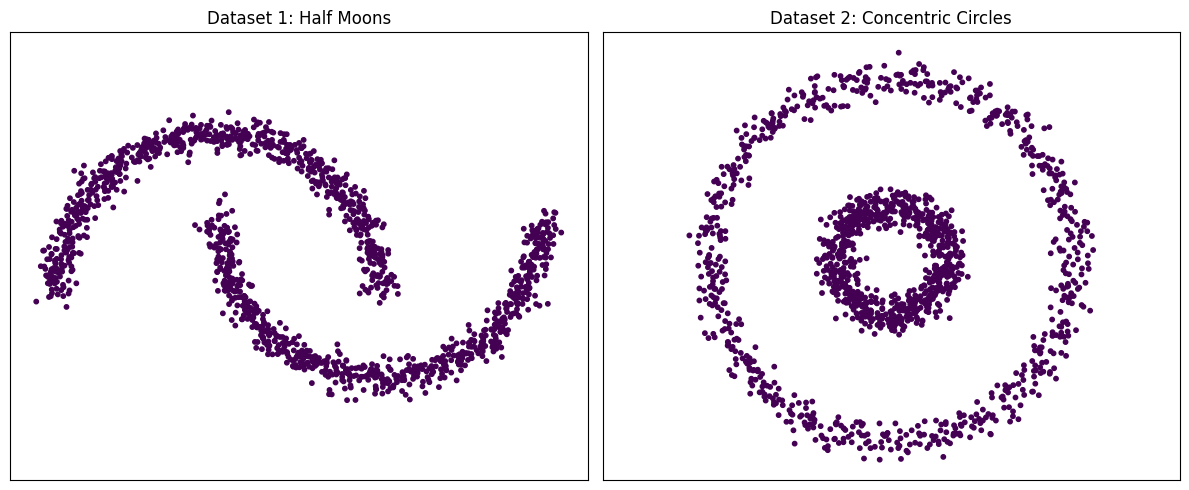

In [28]:

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import pinv, eigh
from sklearn.datasets import make_moons, make_circles
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import pairwise_distances, adjusted_rand_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from skimage import data, color
from skimage.transform import rescale

n_samples = 1500
random_state = 42

X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=0.05, random_state=random_state)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
    plt.title(title)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, np.zeros(n_samples), "Dataset 1: Half Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, np.zeros(n_samples), "Dataset 2: Concentric Circles")
plt.tight_layout()
plt.show()

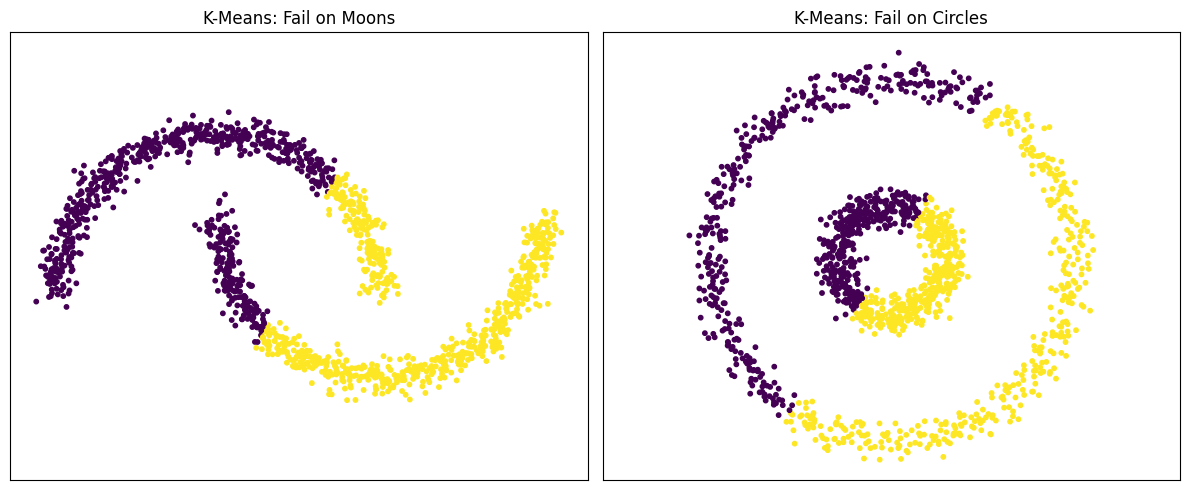

In [29]:
kmeans_moons = KMeans(n_clusters=2, random_state=random_state).fit(X_moons)
kmeans_circles = KMeans(n_clusters=2, random_state=random_state).fit(X_circles)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, kmeans_moons.labels_, "K-Means: Fail on Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, kmeans_circles.labels_, "K-Means: Fail on Circles")
plt.tight_layout()
plt.show()


--- Dataset: Circles ---


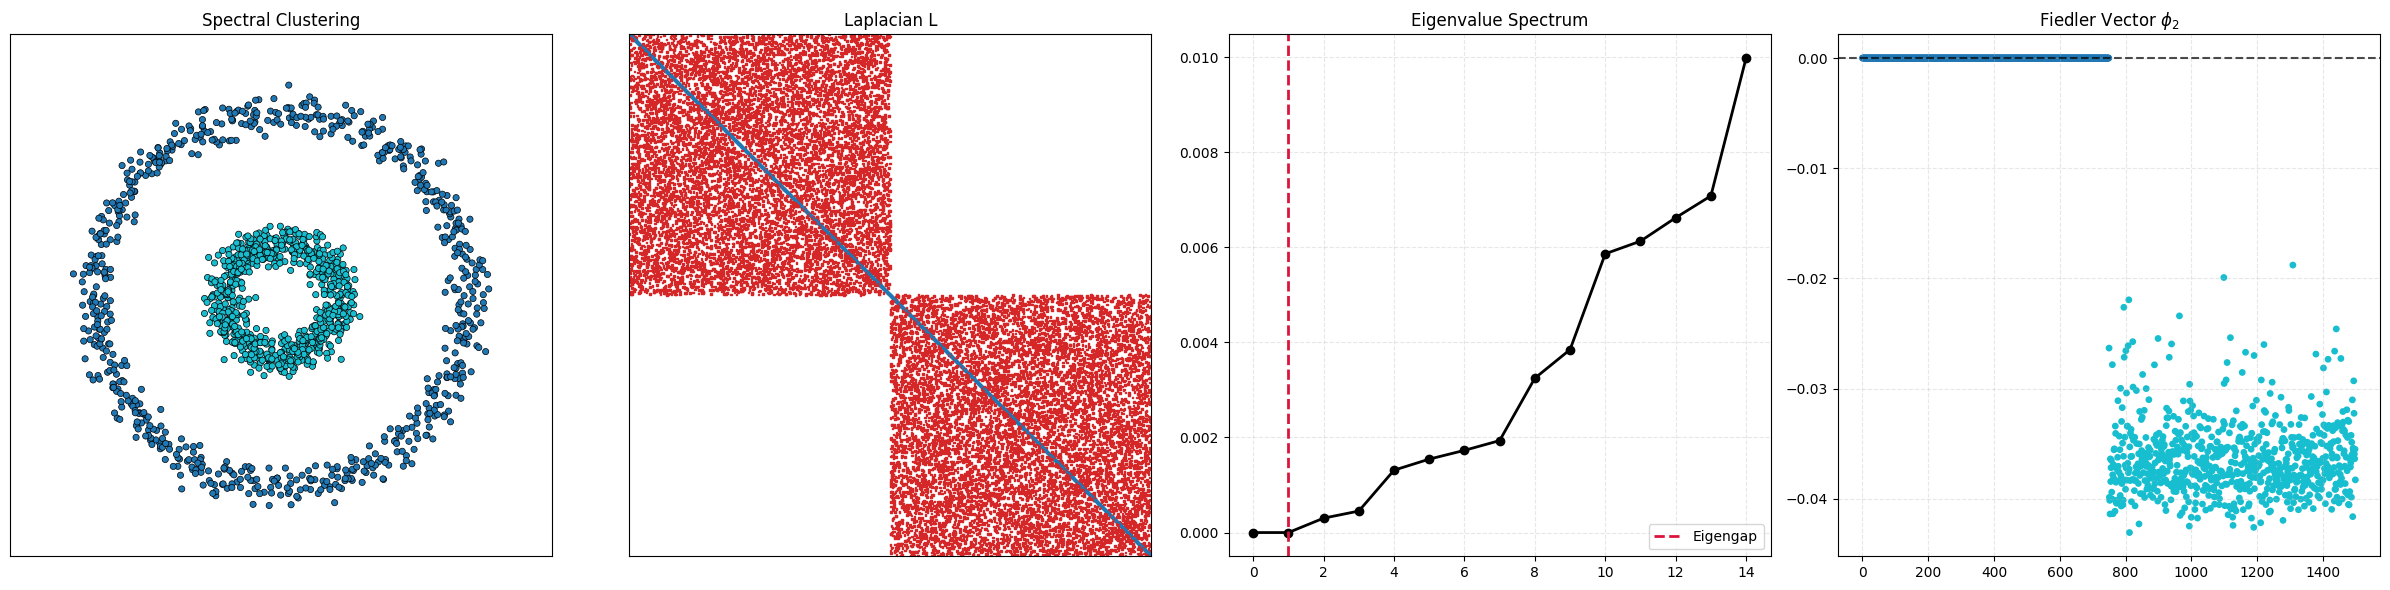

--- Dataset: Moons ---


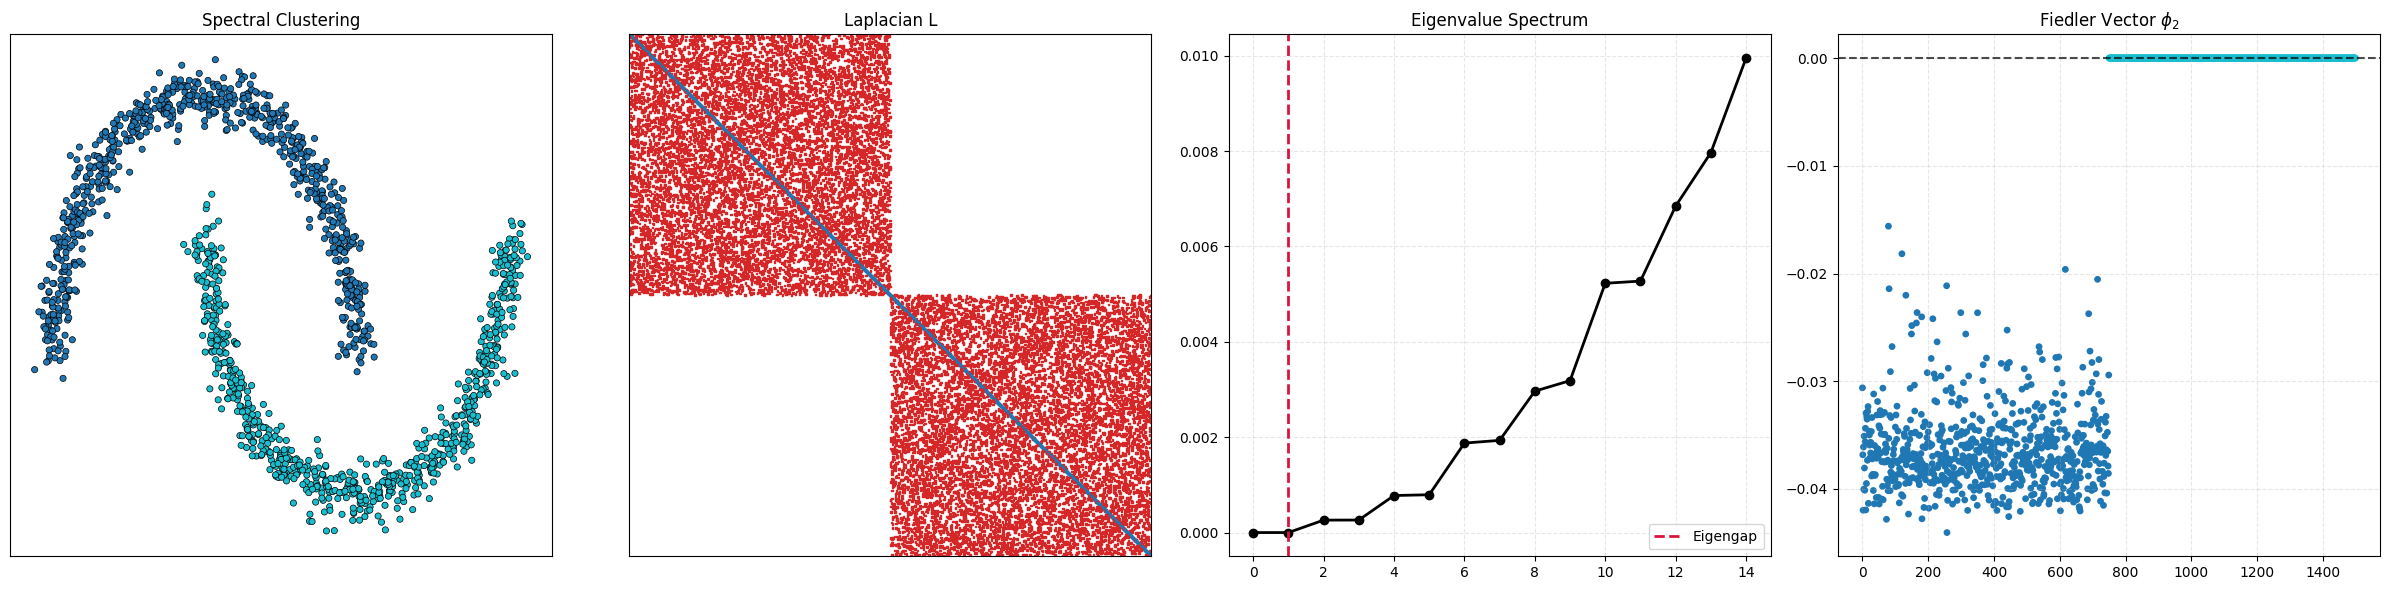

In [30]:
def spectral_clustering_dense(X, n_clusters=2, k_nn=10, plot_results=True):
    N = X.shape[0]

    # 1. Costruzione Grafo (Kernel Adattivo KNN)
    dists = pairwise_distances(X)
    nbrs = NearestNeighbors(n_neighbors=k_nn + 1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    sigma = np.median(distances[:, 1:], axis=1)  
    
    W = np.exp(-(dists ** 2) / (sigma[:, None] * sigma[None, :]))
    W_knn = np.zeros_like(W)
    for i in range(N):
        W_knn[i, indices[i]] = W[i, indices[i]]
        
    W = np.maximum(W_knn, W_knn.T)
    np.fill_diagonal(W, 0)
    
    # 2. Laplaciano Normalizzato
    d = np.sum(W, axis=1)
    d_inv_sqrt = np.zeros_like(d)
    d_inv_sqrt[d > 0] = 1.0 / np.sqrt(d[d > 0])
    D_inv_sqrt = np.diag(d_inv_sqrt)
    L = np.eye(N) - D_inv_sqrt @ W @ D_inv_sqrt
    
    # 3. Decomposizione Spettrale
    eigenvals, eigenvecs = np.linalg.eigh(L)
    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    
    # 4. Clustering (Ng-Jordan-Weiss)
    U = eigenvecs[:, :n_clusters]
    U_norm = U / np.linalg.norm(U, axis=1, keepdims=True)
    labels = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(U_norm)
    
    if plot_results:
        sort_idx = np.argsort(labels)
        fiedler_vec = eigenvecs[:, 1]
        L_sorted = L[sort_idx][:, sort_idx]
        
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        
        axes[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20, edgecolors='k', linewidth=0.5)
        axes[0].set_title("Spectral Clustering")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        axes[0].axis('equal')
        
        rows_L, cols_L = np.where(np.abs(L_sorted) > 0)
        vals_L = L_sorted[rows_L, cols_L]

        colors_L = ['#d62728' if v < 0 else '#1f77b4' for v in vals_L] 
        
        axes[1].scatter(cols_L, rows_L, c=colors_L, s=1.5, marker='s')
        axes[1].set_xlim(0, N); axes[1].set_ylim(N, 0)
        axes[1].set_aspect('equal')
        axes[1].set_title("Laplacian L")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
        axes[2].plot(eigenvals[:15], 'o-', color='black', linewidth=2, markersize=6)
        axes[2].axvline(x=n_clusters-1, color='crimson', linestyle='--', linewidth=2, label='Eigengap')
        axes[2].set_title("Eigenvalue Spectrum")
        axes[2].grid(True, alpha=0.3, linestyle='--')
        axes[2].legend()
        
        axes[3].scatter(range(N), fiedler_vec[sort_idx], c=labels[sort_idx], cmap='tab10', s=15)
        axes[3].axhline(y=0, color='k', ls='--', alpha=0.7)  
        axes[3].set_title(r"Fiedler Vector $\phi_2$")
        axes[3].grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
    
    return labels
    
scaler = StandardScaler() 
X_moons_std = scaler.fit_transform(X_moons) 
X_circles_std = scaler.fit_transform(X_circles)

print("--- Dataset: Circles ---")
_ = spectral_clustering_dense(X_circles_std, n_clusters=2, k_nn=10)

print("--- Dataset: Moons ---")
_ = spectral_clustering_dense(X_moons_std, n_clusters=2, k_nn=10)

### VECCHIA FUNZIONE SPECTRAL CLUSTERING 

In [38]:
def spectral_clustering_dense_vecchia(X, n_clusters, sigma=0.5):
    N = X.shape[0]
    
    dists = pairwise_distances(X, metric='euclidean')
    W = np.exp(- (dists ** 2) / (2 * sigma ** 2))
    np.fill_diagonal(W, 0) # Rimuoviamo self-loops
    
    d = np.sum(W, axis=1)
    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    
    I = np.eye(N)
    L_sym = I - D_inv_sqrt @ W @ D_inv_sqrt

    eigenvals, eigenvecs = np.linalg.eigh(L_sym)
    U = eigenvecs[:, :n_clusters]
    
    rows_norm = np.linalg.norm(U, axis=1, keepdims=True)
    rows_norm[rows_norm == 0] = 1 
    U_normalized = U / rows_norm
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(U_normalized)
    
    return labels

--- Dataset: Circles ---


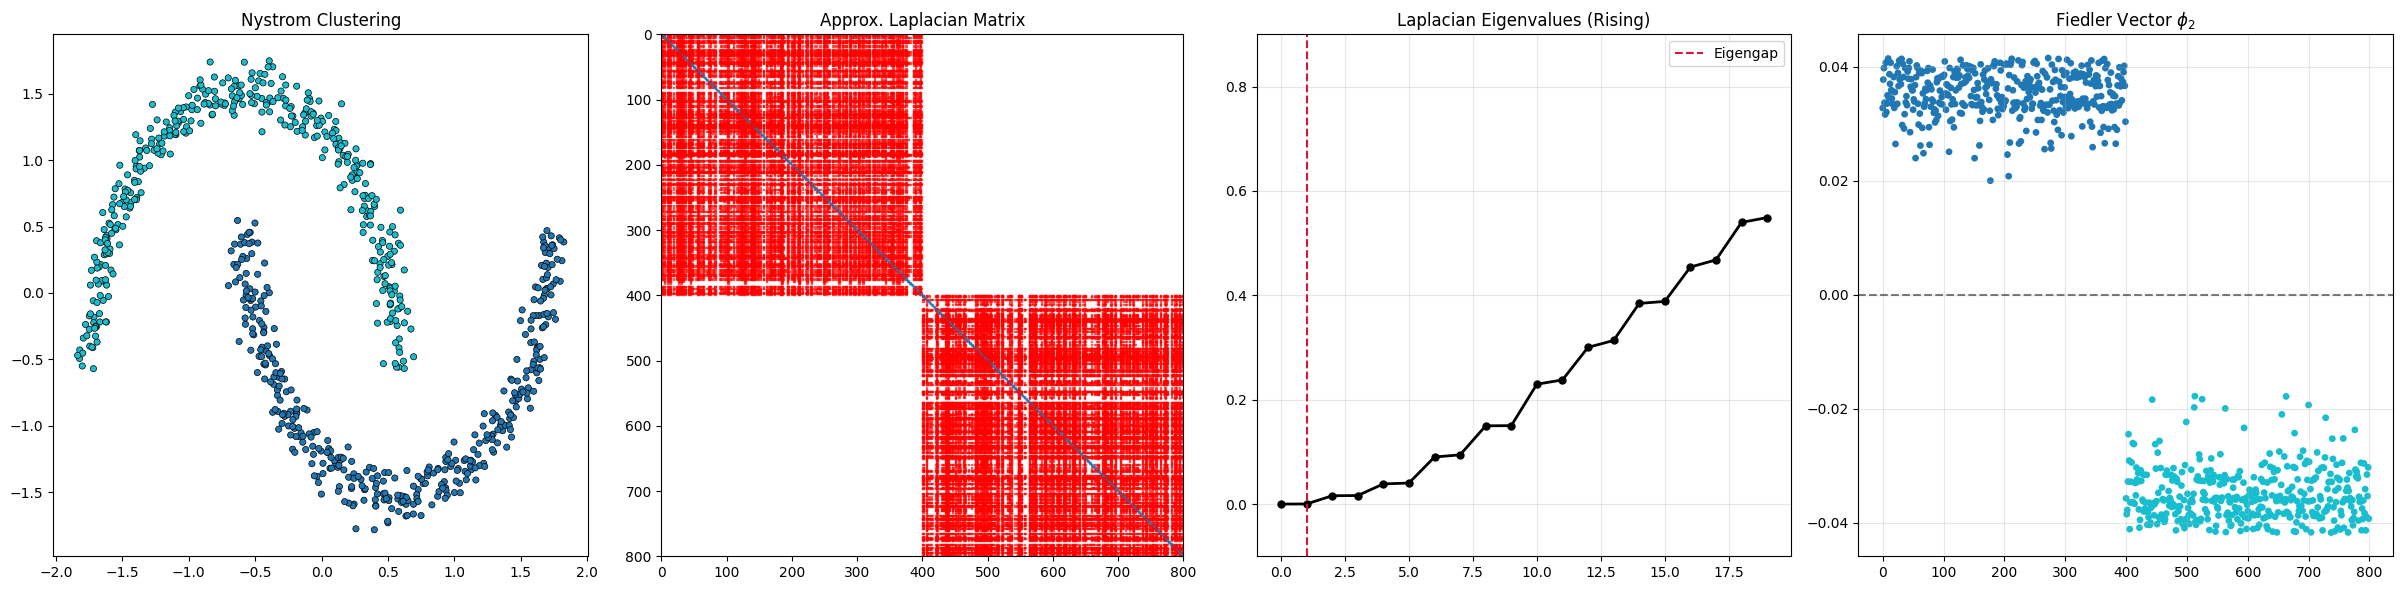

--- Dataset: Moons ---


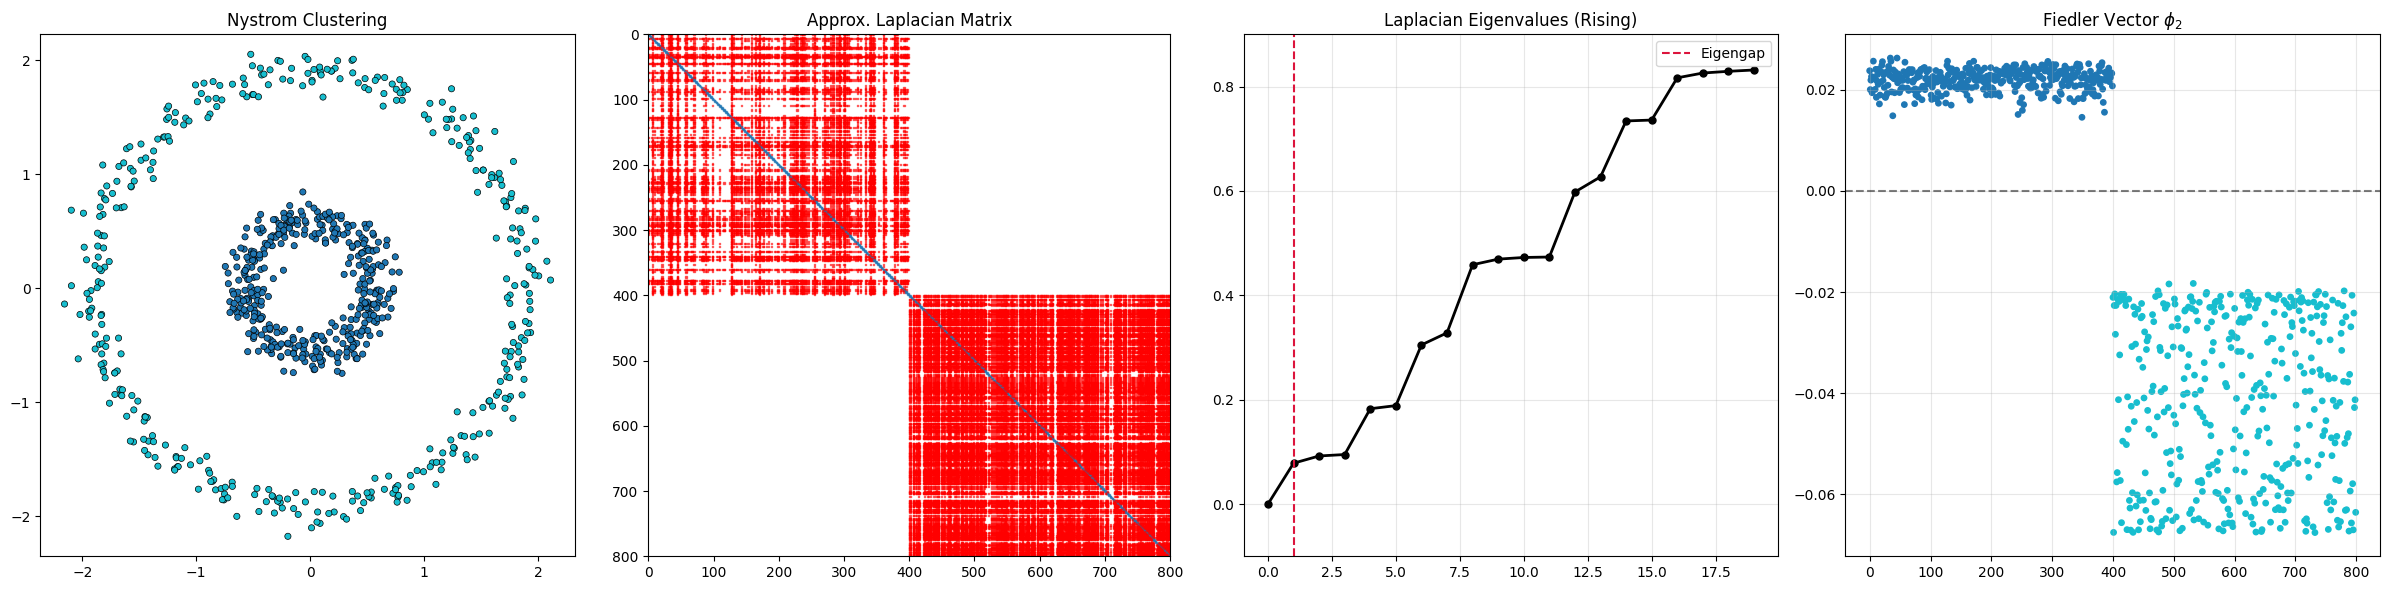

In [ ]:
def nystrom_fowlkes_spectra_clustering(X, m, n_clusters, gamma=None):
    n = X.shape[0]
    if gamma is None:
        gamma = 1.0 / (2 * np.median(np.var(X, axis=0)))

    indices = np.random.choice(n, m, replace=False)
    mask = np.zeros(n, dtype=bool)
    mask[indices] = True
    
    X_sampled = X[mask]
    X_remaining = X[~mask]
    
    
    A = rbf_kernel(X_sampled, X_sampled, gamma=gamma)
    B = rbf_kernel(X_remaining, X_sampled, gamma=gamma)

    d = np.concatenate([
        np.sum(A, axis=1) + np.sum(B.T, axis=1),
        np.sum(B, axis=1) + B @ (np.linalg.pinv(A) @ np.sum(B.T, axis=1))
    ])
    d_inv_sqrt = 1.0 / np.sqrt(d + 1e-10)
    d_m = d_inv_sqrt[:m]
    d_nm = d_inv_sqrt[m:]
    
    A_norm = np.diag(d_m) @ A @ np.diag(d_m)
    B_norm = np.diag(d_nm) @ B @ np.diag(d_m)

    v_eigenvals, U = np.linalg.eigh(A_norm)
    v_eigenvals = np.maximum(v_eigenvals[::-1], 1e-10)
    U = U[:, ::-1]

    A_inv_sqrt = U @ np.diag(1.0 / np.sqrt(v_eigenvals)) @ U.T

    Q = A_norm + A_inv_sqrt @ (B_norm.T @ B_norm) @ A_inv_sqrt
    v_q, U_q = np.linalg.eigh(Q)
    v_q = np.maximum(v_q[::-1], 1e-10)
    U_q = U_q[:, ::-1]

    combined_AB_norm = np.zeros((n, m))
    combined_AB_norm[mask] = A_norm
    combined_AB_norm[~mask] = B_norm
    
    V_final = combined_AB_norm @ A_inv_sqrt @ U_q @ np.diag(1.0 / np.sqrt(v_q))

    V_k = V_final[:, :n_clusters] 
    
    row_norms = np.linalg.norm(V_k, axis=1, keepdims=True)
    V_normalized = V_k / (row_norms + 1e-10)

    labels= KMeans(n_clusters=n_clusters, n_init=10).fit_predict(V_normalized)
    return labels, v_q,  V_final


def plot_nystrom_results(X, labels, v_q, V_final, n_clusters):
    n = X.shape[0]
    sort_idx = np.argsort(labels)
    laplacian_evals = np.sort(1.0 - v_q) 

    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    ax[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=20, edgecolors='k', linewidth=0.5)
    ax[0].set_title("Nystrom Clustering")
    ax[0].axis('equal')

    W_approx = V_final[:, :n_clusters] @ V_final[:, :n_clusters].T
    L_approx = np.eye(n) - W_approx
    L_sorted = L_approx[sort_idx][:, sort_idx]

    threshold = np.percentile(np.abs(L_sorted), 90) 
    rows, cols = np.where(np.abs(L_sorted) > threshold)
    vals = L_sorted[rows, cols]
    
    colors = ['red' if v < 0 else '#1f77b4' for v in vals]
    ax[1].scatter(cols, rows, c=colors, s=0.8, marker='s', alpha=0.6)
    ax[1].set_xlim(0, n); 
    ax[1].set_ylim(n, 0)
    ax[1].set_aspect('equal')
    ax[1].set_title("Approx. Laplacian Matrix")

   
    ax[2].plot(laplacian_evals[:20], 'o-', color='black', linewidth=2, markersize=5)
    ax[2].axvline(x=n_clusters-1, color='crimson', linestyle='--', label='Eigengap')
    ax[2].set_title("Laplacian Eigenvalues (Rising)")
    ax[2].grid(True, alpha=0.3)
    ax[2].set_ylim(-0.1, 0.9) 
    ax[2].legend()

  
    fiedler_vec = V_final[:, 1]
    ax[3].scatter(range(n), fiedler_vec[sort_idx], c=labels[sort_idx], cmap='tab10', s=15)
    ax[3].axhline(y=0, color='k', ls='--', alpha=0.5)
    ax[3].set_title(r"Fiedler Vector $\phi_2$")
    ax[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)
X_circles_scaled = scaler.fit_transform(X_circles)

labels_nystrom_moons, evals_moons, evects_moons = nystrom_fowlkes_spectra_clustering(X_moons_scaled, m=150, n_clusters=2, gamma=10.0)
labels_nystrom_circles, evals_circles, evects_circles = nystrom_fowlkes_spectra_clustering(X_circles_scaled, m=150, n_clusters=2, gamma=2.0)

print("--- Dataset: Circles ---")
plot_nystrom_results(X_moons_scaled, labels_nystrom_moons, evals_moons, evects_moons, n_clusters=2)

print("--- Dataset: Moons ---")
plot_nystrom_results(X_circles_scaled, labels_nystrom_circles, evals_circles, evects_circles, n_clusters=2)

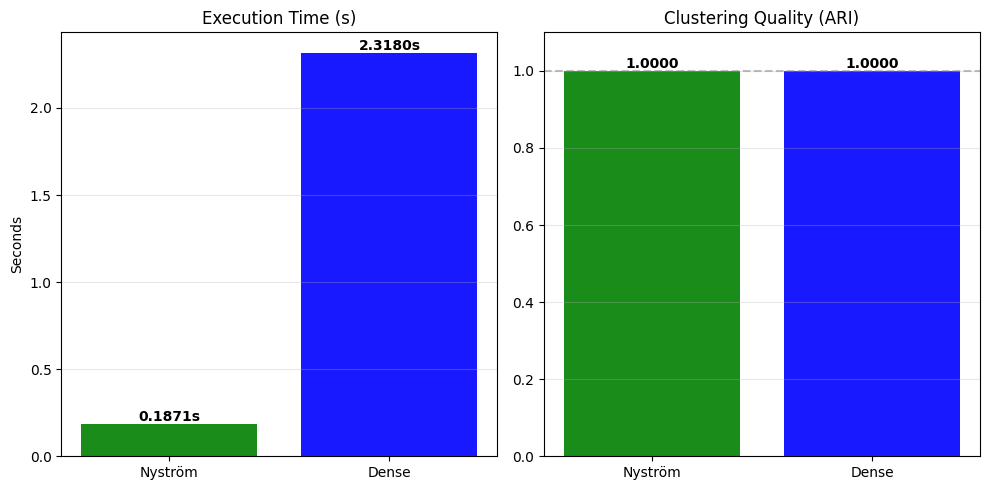

In [31]:
k = 2
m = 100
gamma = 15.0
k_nn = 10

t0 = time.time()
labels_nys, _, _ = nystrom_fowlkes_spectra_clustering(X_circles_std, n_clusters=k, m=m, gamma=gamma)
t_nys = time.time() - t0
ari_nys = adjusted_rand_score(y_circles, labels_nys)

t0 = time.time()
labels_dense = spectral_clustering_dense(X_circles_std, n_clusters=k, k_nn=k_nn, plot_results=False)
t_dense = time.time() - t0
ari_dense = adjusted_rand_score(y_circles, labels_dense)

methods = ["Nyström", "Dense"]
times = [t_nys, t_dense]
aris = [ari_nys, ari_dense]
colors = ['green', 'blue']  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

bars1 = axes[0].bar(methods, times, color=colors, alpha=0.9)
axes[0].set_title("Execution Time (s)")
axes[0].set_ylabel("Seconds")
axes[0].grid(axis="y", alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}s', ha='center', va='bottom', fontweight='bold')

bars2 = axes[1].bar(methods, aris, color=colors, alpha=0.9)
axes[1].set_title("Clustering Quality (ARI)")
axes[1].set_ylim(0, 1.1)
axes[1].axhline(1.0, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(axis="y", alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### DA QUI IN POI PARTE DI NINA DA FINIRE DI SISTEMARE (FACCIO SUL MIO BRANCH E POI COPIO QUI)

## Dataset Coins Trade Off between Quality and Speed



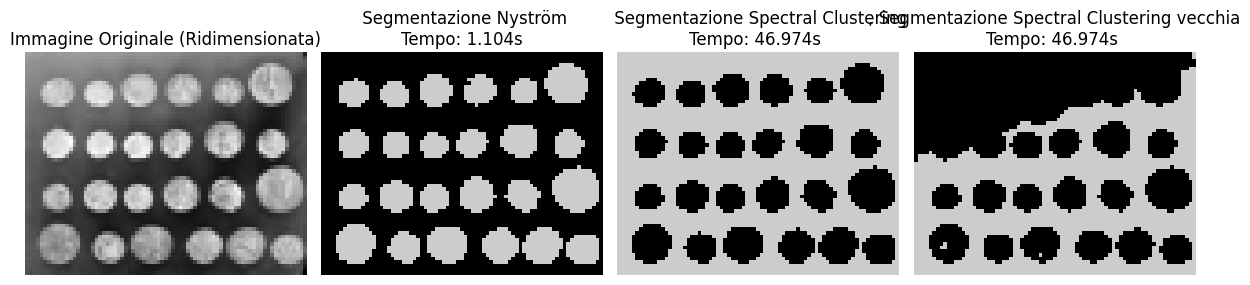

Velocità: Nyström è 42.5 volte più veloce del metodo Dense.


In [ ]:

image = data.coins()
image_rescaled = rescale(image, 0.2, anti_aliasing=True) 
rows, cols = image_rescaled.shape

r_coords, c_coords = np.indices((rows, cols))
X_img = np.column_stack([
    r_coords.ravel(), 
    c_coords.ravel(), 
    image_rescaled.ravel() * 500 
])

X_img_scaled = StandardScaler().fit_transform(X_img)

n_cl = 2
t0=time.time()
labels_nys, _, _  = nystrom_fowlkes_spectra_clustering(X_img_scaled, m=200, n_clusters=n_cl, gamma=5.0)
t_nys=time.time()-t0

t0=time.time()
labels_dense = spectral_clustering_dense(X_img_scaled, n_clusters=n_cl, k_nn=1000, plot_results=False)
t_dense=time.time()-t0

t0=time.time()
labels_dense_vecchia = spectral_clustering_dense_vecchia(X_img_scaled, n_clusters=n_cl, sigma=0.5)
t_dense=time.time()-t0

segmentation_nys = labels_nys.reshape((rows, cols))
segmentation_dense= labels_dense.reshape((rows, cols))
segmentation_dense_vecchia= labels_dense_vecchia.reshape((rows, cols))

fig, ax = plt.subplots(1, 4, figsize=(12, 6))

ax[0].imshow(image_rescaled, cmap='gray')
ax[0].set_title("Immagine Originale (Ridimensionata)")
ax[0].axis('off')

ax[1].imshow(segmentation_nys, cmap='nipy_spectral')
ax[1].set_title(f" Segmentazione Nyström\nTempo: {t_nys:.3f}s")
ax[1].axis('off')

ax[2].imshow(segmentation_dense_vecchia, cmap='nipy_spectral')
ax[2].set_title(f" Segmentazione Spectral Clustering vecchia\nTempo: {t_dense:.3f}s ")
ax[2].axis('off')

ax[3].imshow(segmentation_dense, cmap='nipy_spectral')
ax[3].set_title(f", Segmentazione Spectral Clustering \nTempo: {t_dense:.3f}s ")
ax[3].axis('off')

plt.tight_layout()
plt.show()

print(f"Velocità: Nyström è {t_dense / t_nys:.1f} volte più veloce del metodo Dense.")




Test Astronauta: 23716 pixel e 5 Feature (x, y, R, G, B)


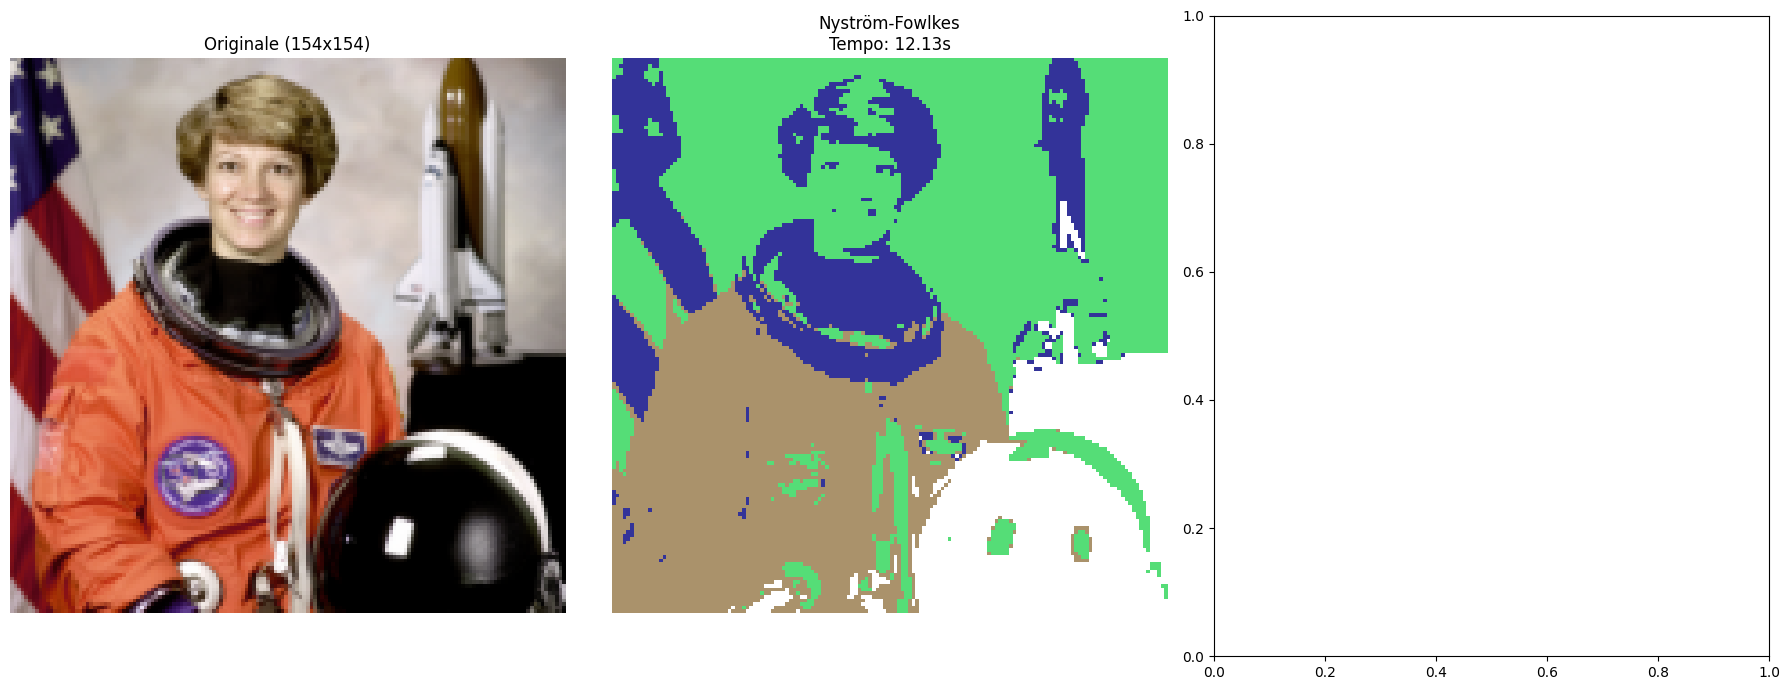

In [37]:
from skimage import data
from sklearn.preprocessing import StandardScaler
import time

# 1. Carichiamo l'astronauta (immagine a colori)
img_astro = data.astronaut()

# Definiamo una scala che renda l'immagine "proibitiva" per il Dense
# Con 0.15 abbiamo circa 11.500 pixel. 
# Per il Dense significa una matrice 11.500 x 11.500 (circa 1GB solo di RAM)
scale_factor = 0.30
img_res = rescale(img_astro, scale_factor, channel_axis=-1, anti_aliasing=True)
rows, cols, dims = img_res.shape
n_pixels = rows * cols

# 2. Creazione Feature Vector (x, y, R, G, B)
r_coords, c_coords = np.indices((rows, cols))
X_astro = np.column_stack([
    r_coords.ravel() * 1.5, 
    c_coords.ravel() * 1.5, 
    img_res[:,:,0].ravel() * 150, # Canale R
    img_res[:,:,1].ravel() * 150, # Canale G
    img_res[:,:,2].ravel() * 1500  # Canale B
])

X_scaled = StandardScaler().fit_transform(X_astro)

print(f"Test Astronauta: {n_pixels} pixel e 5 Feature (x, y, R, G, B)")

# 3. Esecuzione Nyström-Fowlkes
# Usiamo n_clusters=4 per provare a separare: tuta, viso, sfondo scuro, bandiera/dettagli
start_nyst = time.time()
labels_nyst = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=4, gamma=1.3)
time_nyst = time.time() - start_nyst

# 4. Esecuzione Spectral Dense (Tuo)
'''print("Calcolo Dense in corso... (prepara la pazienza)")
start_dense = time.time()
try:
    labels_dense = spectral_clustering_dense(X_scaled, n_clusters=4, sigma=0.8)
    time_dense = time.time() - start_dense
except MemoryError:
    labels_dense = None
    print("❌ Il metodo Dense è crashato!")'''

# 5. Visualizzazione
fig, ax = plt.subplots(1, 3, figsize=(18, 7))

ax[0].imshow(img_res)
ax[0].set_title(f"Originale ({rows}x{cols})")
ax[0].axis('off')

ax[1].imshow(labels_nyst.reshape(rows, cols), cmap='terrain')
ax[1].set_title(f"Nyström-Fowlkes\nTempo: {time_nyst:.2f}s")
ax[1].axis('off')

'''if labels_dense is not None:
    ax[2].imshow(labels_dense.reshape(rows, cols), cmap='terrain')
    ax[2].set_title(f"Dense (Tuo)\nTempo: {time_dense:.2f}s")
else:
    ax[2].text(0.5, 0.5, "MEMORY ERROR", ha='center', va='center', color='red', fontsize=15)
    ax[2].set_title("Dense (Tuo)")
ax[2].axis('off')'''

plt.tight_layout()
plt.show()

Dataset: Astronauta | Pixel: 23716 | Dimensioni: 154x154
Elaborazione Gamma=0.3...
Elaborazione Gamma=1.3...
Elaborazione Gamma=5.0...
Elaborazione Gamma=8.0...
Elaborazione Gamma=10.0...
Elaborazione Gamma=15.0...


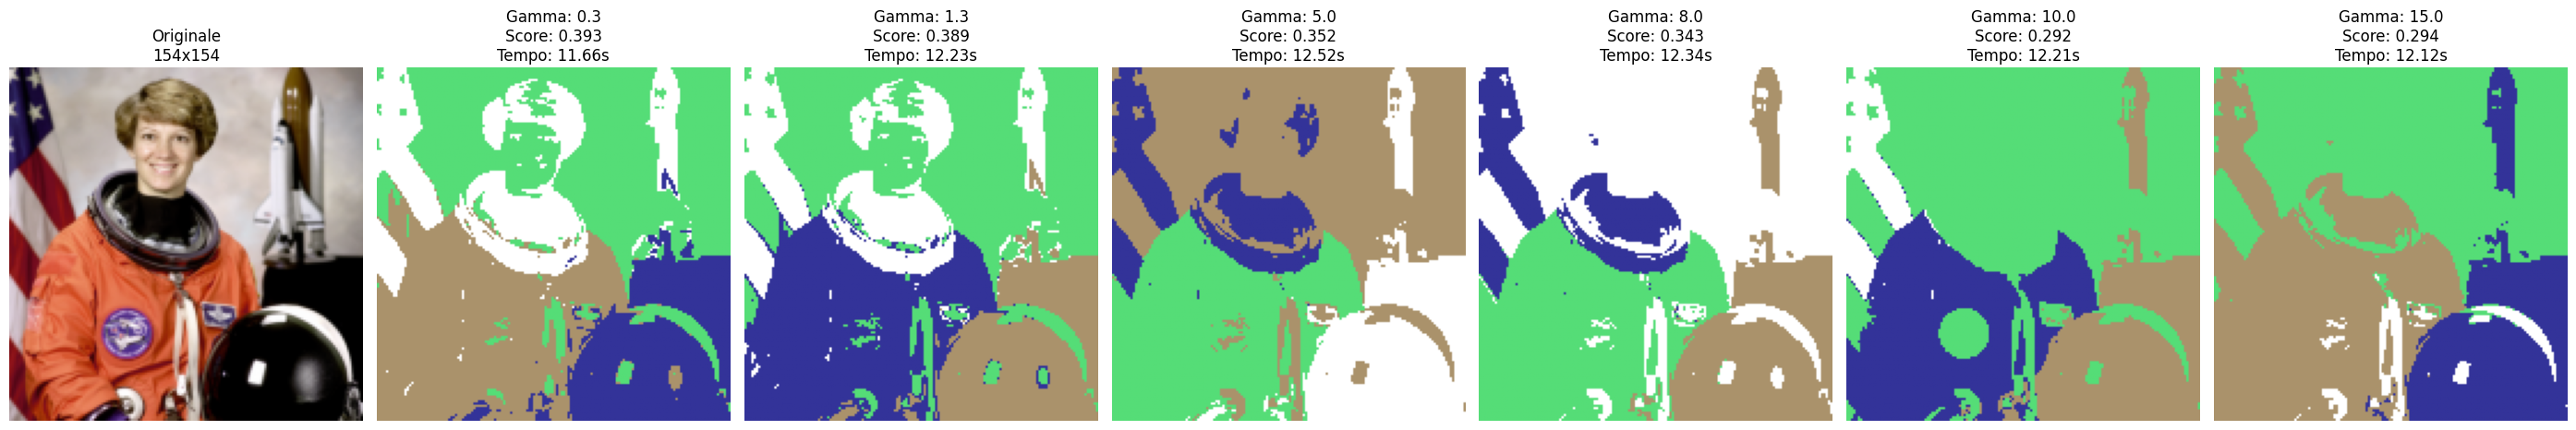

--------------------------------------------------
Analisi completata.
Il Gamma che offre la migliore separazione è 0.3 con uno score di 0.3926.


In [38]:
###CON ANALISI DEL MIGLIORE GAMMA USANDO LA SILHOUETTE SCORE ---TROVATO CHE IL MIGLIROE E' 1.3 

import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import data
from skimage.transform import rescale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- 1. PREPARAZIONE DATASET (ASTRONAUT) ---
img_astro = data.astronaut()

# Scala al 30% per avere circa 45.000-50.000 pixel
scale_factor = 0.30
img_res = rescale(img_astro, scale_factor, channel_axis=-1, anti_aliasing=True)
rows, cols, dims = img_res.shape
n_pixels = rows * cols

# Creazione Feature Vector: Posizione (x,y) + Colore (R,G,B)
r_coords, c_coords = np.indices((rows, cols))
X_astro = np.column_stack([
    r_coords.ravel(), 
    c_coords.ravel(), 
    img_res[:,:,0].ravel() * 300, # Peso per il canale Rosso
    img_res[:,:,1].ravel() * 300, # Peso per il canale Verde
    img_res[:,:,2].ravel() * 300  # Peso per il canale Blu
])

# Normalizzazione fondamentale per lo Spectral Clustering
X_scaled = StandardScaler().fit_transform(X_astro)

print(f"Dataset: Astronauta | Pixel: {n_pixels} | Dimensioni: {rows}x{cols}")

# --- 2. ANALISI DEI PARAMETRI GAMMA ---
gamma_values = [0.3, 1.3, 5.0, 8.0, 10.0, 15.0]
results = []

for g in gamma_values:
    print(f"Elaborazione Gamma={g}...")
    t_start = time.time()
    
    # Eseguiamo Nyström-Fowlkes (m=300 è circa lo 0.6% dei dati)
    labels = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=4, gamma=g)
    
    t_end = time.time() - t_start
    
    # Calcolo Silhouette Score su un campione di 1000 pixel per velocità
    sample_idx = np.random.choice(n_pixels, 1000, replace=False)
    score = silhouette_score(X_scaled[sample_idx], labels[sample_idx])
    
    results.append({
        'gamma': g,
        'labels': labels,
        'time': t_end,
        'score': score
    })

# --- 3. VISUALIZZAZIONE RISULTATI ---
n_plots = len(gamma_values) + 1
fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 5))

# Plot Immagine Originale
axes[0].imshow(img_res)
axes[0].set_title(f"Originale\n{rows}x{cols}")
axes[0].axis('off')

# Plot dei vari Gamma
for i, res in enumerate(results):
    seg_map = res['labels'].reshape(rows, cols)
    axes[i+1].imshow(seg_map, cmap='terrain')
    title = (f"Gamma: {res['gamma']}\n"
             f"Score: {res['score']:.3f}\n"
             f"Tempo: {res['time']:.2f}s")
    axes[i+1].set_title(title)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# --- 4. CONCLUSIONI ---
best_res = max(results, key=lambda x: x['score'])
print("-" * 50)
print(f"Analisi completata.")
print(f"Il Gamma che offre la migliore separazione è {best_res['gamma']} "
      f"con uno score di {best_res['score']:.4f}.")

Test su 32041 pixel. Matrice Dense occuperebbe circa 8 GB.
⚠️ Saltiamo il metodo Dense: 32041 pixel richiederebbero più di 2 minuti e troppa RAM.
In un'analisi reale, questo è il punto in cui lo Spectral Clustering standard fallisce.

--- Tentativo Spectral Clustering Dense ---

--- Esecuzione Nyström-Fowlkes (Versione Finale) ---
✅ Nyström completato con successo in 35.47s


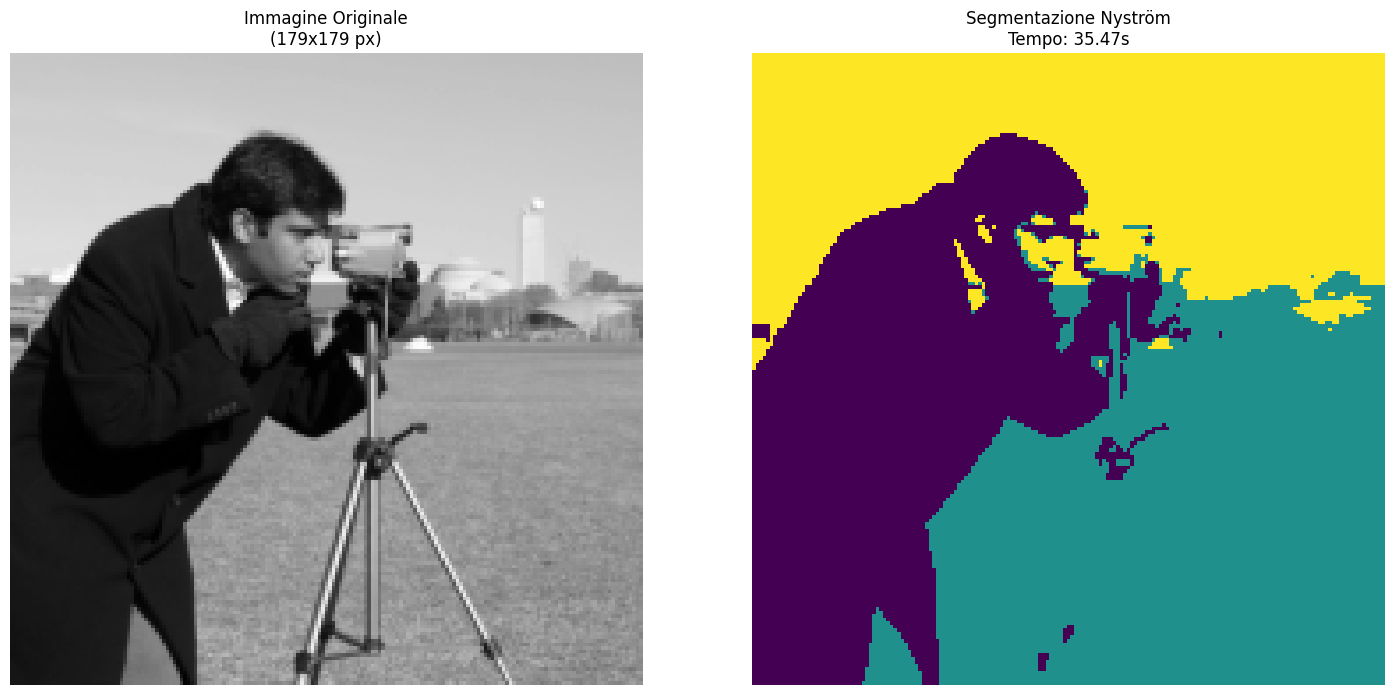

In [ ]:
##PROVIAMO CON IMMAGINE DEL FOTOGRAFO PER VEDERE SE OTTENGO RISULTATO MEZZO DECENTE CON NYMSTROM

img = data.camera()


scale_factor = 0.35 
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols


r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([
    r_coords.ravel() * 150 , 
    c_coords.ravel() * 150,
    img_res.ravel() * 300
])
X_scaled = StandardScaler().fit_transform(X_cam)

print(f"Test su {n_pixels} pixel. Matrice Dense occuperebbe circa 8 GB.")
limit_pixel = 20000
if n_pixels > limit_pixel:
    print(f" Saltiamo il metodo Dense: {n_pixels} pixel richiederebbero più di 2 minuti e troppa RAM.")
    print("In un'analisi reale, questo è il punto in cui lo Spectral Clustering standard fallisce.")
else:
    start_d = time.time()
    labels_dense = spectral_clustering_dense(X_scaled, n_clusters=3, sigma=0.5)
    print(f"Dense completato in {time.time()-start_d:.2f}s")


print("\n--- Esecuzione Nyström-Fowlkes (Versione Finale) ---")
start_n = time.time()

labels_nyst, _, _ = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=3, gamma=6.0)
time_nyst = time.time() - start_n
print(f" Nyström completato con successo in {time_nyst:.2f}s")


fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(img_res, cmap='gray')
ax[0].set_title(f"Immagine Originale\n({rows}x{cols} px)")
ax[0].axis('off')

ax[1].imshow(labels_nyst.reshape(rows, cols), cmap='viridis')
ax[1].set_title(f"Segmentazione Nyström\nTempo: {time_nyst:.2f}s")
ax[1].axis('off')

plt.tight_layout()
plt.show()


In [44]:
def gamma_best(X, n_clusters, gamma_candidates, m_test=300, silhouette_samples=1000):
    """
    Esegue una ricerca del miglior parametro gamma per Nyström usando il Silhouette Score.
    """
    n_pixels = X.shape[0]
    results = []
    
    print(f"Avvio analisi Silhouette su {len(gamma_candidates)} candidati...")
    
    for g in gamma_candidates:
        # Esecuzione rapida di Nyström per il test
        # Assicurati che la tua funzione restituisca (labels, evals, evecs)
        # Qui prendiamo solo le labels [0]
        labels_tmp, _, _ = nystrom_fowlkes_spectra_clustering(X, m=m_test, n_clusters=n_clusters, gamma=g)
        
        # Sottocampionamento per calcolo veloce Silhouette
        sample_size = min(silhouette_samples, n_pixels)
        idx = np.random.choice(n_pixels, sample_size, replace=False)
        
        score = silhouette_score(X[idx], labels_tmp[idx])
        results.append({
            'gamma': g,
            'score': score,
            'labels': labels_tmp
        })
        print(f"  > Gamma {g:.2f} | Silhouette Score: {score:.4f}")
    
    # Trova il miglior risultato
    best_res = max(results, key=lambda x: x['score'])
    return best_res, results

def plot_gamma_search(img_res, search_results):
    
    rows, cols = img_res.shape
    n_tests = len(search_results)
    fig, axes = plt.subplots(1, n_tests + 1, figsize=(4 * (n_tests + 1), 5))

    axes[0].imshow(img_res, cmap='gray')
    axes[0].set_title("Originale")
    axes[0].axis('off')

    for i, res in enumerate(search_results):
        axes[i+1].imshow(res['labels'].reshape(rows, cols), cmap='viridis')
        axes[i+1].set_title(f"Gamma: {res['gamma']}\nScore: {res['score']:.3f}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

Avvio analisi Silhouette su 5 candidati...
  > Gamma 6.00 | Silhouette Score: 0.4532
  > Gamma 6.20 | Silhouette Score: 0.4595
  > Gamma 6.50 | Silhouette Score: 0.4526
  > Gamma 6.70 | Silhouette Score: 0.4529
  > Gamma 6.90 | Silhouette Score: 0.4622

✅ Miglior Gamma: 6.9 con Score: 0.4622


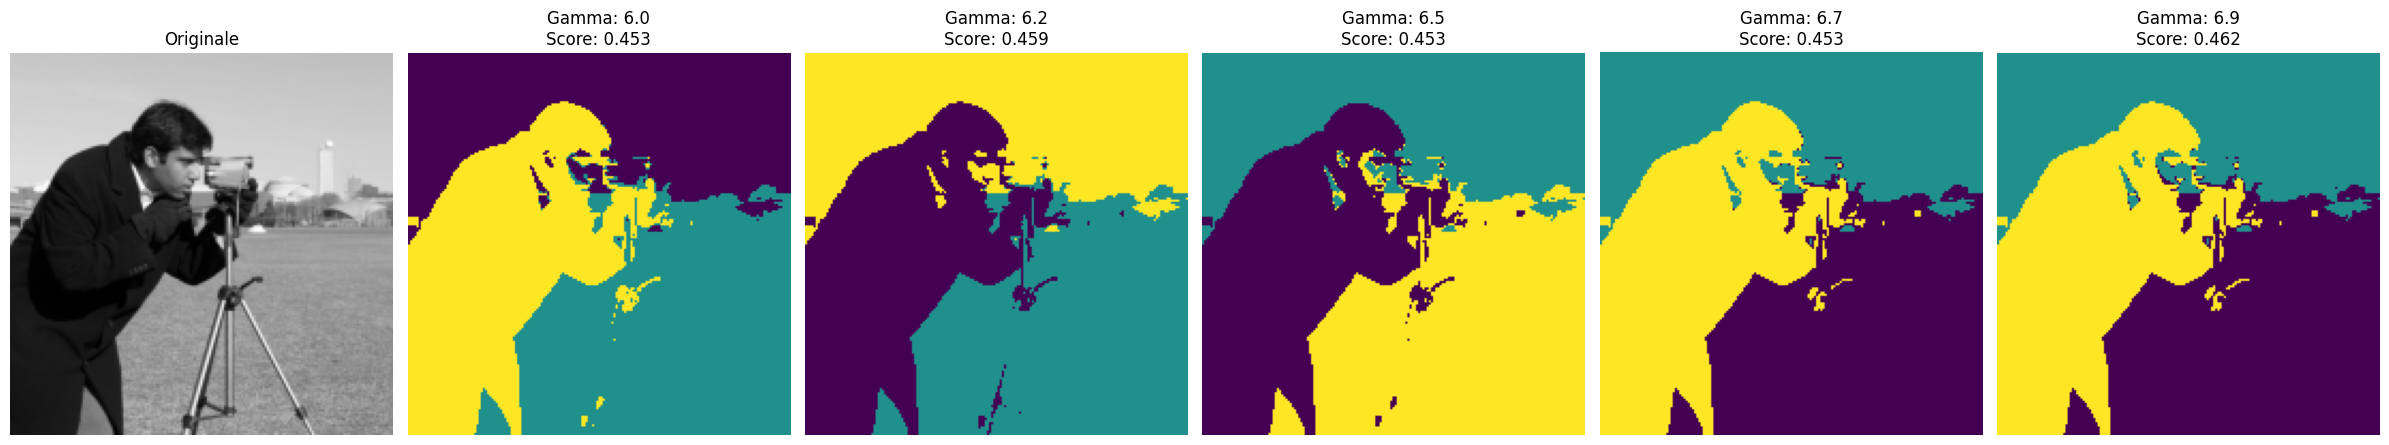

Esecuzione finale con m=500...


KeyboardInterrupt: 

In [ ]:
img = data.camera()
scale_factor = 0.40  # Risoluzione media per un test significativo
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols

r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([
    r_coords.ravel() * 1.5, 
    c_coords.ravel() * 1.5, 
    img_res.ravel() * 100
])
X_scaled = StandardScaler().fit_transform(X_cam)
gamma_candidates = [6.0, 6.2, 6.5, 6.7, 6.9]
best_result, all_results = gamma_best(X_scaled, n_clusters=3, gamma_candidates=gamma_candidates)

print(f"Miglior Gamma: {best_result['gamma']} con Score: {best_result['score']:.4f}")

# --- 3. Plot dei risultati della ricerca ---
plot_gamma_search(img_res, all_results)

# --- 4. Esecuzione Finale (opzionale, con m più alto) ---
print(f"Esecuzione finale con m=500...")
labels_final, evals, evecs = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=3, gamma=best_result['gamma'])

In [ ]:

# --- 1. PREPARAZIONE DATASET ---
img = data.camera()
scale_factor = 0.40  # Risoluzione media per un test significativo
img_res = rescale(img, scale_factor, anti_aliasing=True)
rows, cols = img_res.shape
n_pixels = rows * cols

r_coords, c_coords = np.indices((rows, cols))
X_cam = np.column_stack([
    r_coords.ravel() * 1.5, 
    c_coords.ravel() * 1.5, 
    img_res.ravel() * 100
])
X_scaled = StandardScaler().fit_transform(X_cam)

print(f"Analisi su {n_pixels} pixel.")

# --- 2. RICERCA DEL MIGLIOR GAMMA CON SILHOUETTE ---
gamma_candidates =  [6.0, 6.2, 6.5, 6.7, 6.9]
gamma_results = []

print("\nAvvio analisi Silhouette per trovare il miglior Gamma...")

for g in gamma_candidates:
    # Usiamo m=300 per i test veloci di gamma
    labels_tmp = nystrom_fowlkes_spectra_clustering(X_scaled, m=300, n_clusters=3, gamma=g)
    
    # Sottocampionamento per calcolare la Silhouette velocemente
    sample_size = min(1000, n_pixels)
    idx = np.random.choice(n_pixels, sample_size, replace=False)
    
    score = silhouette_score(X_scaled[idx], labels_tmp[idx])
    gamma_results.append((g, score, labels_tmp))
    print(f"Gamma {g:4.1f} | Silhouette Score: {score:.4f}")

# Troviamo il vincitore
best_gamma, best_score, _ = max(gamma_results, key=lambda x: x[1])
print(f"\n✅ Miglior Gamma trovato: {best_gamma} (Score: {best_score:.4f})")

# --- 3. ESECUZIONE FINALE CON MIGLIOR GAMMA ---
# Usiamo m=500 per la qualità definitiva
print(f"\nEsecuzione finale Nyström con Gamma={best_gamma} e m=500...")
labels_final = nystrom_fowlkes_spectra_clustering(X_scaled, m=500, n_clusters=3, gamma=best_gamma)

# --- 4. VISUALIZZAZIONE ---
n_cols = len(gamma_candidates) + 1
fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 5))

# Immagine originale
axes[0].imshow(img_res, cmap='gray')
axes[0].set_title("Originale")
axes[0].axis('off')

# Plot dei vari test di gamma
for i, (g, score, l_plot) in enumerate(gamma_results):
    axes[i+1].imshow(l_plot.reshape(rows, cols), cmap='viridis')
    axes[i+1].set_title(f"Gamma: {g}\nScore: {score:.3f}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

Analisi su 42025 pixel.

Avvio analisi Silhouette per trovare il miglior Gamma...


TypeError: only integer scalar arrays can be converted to a scalar index